This google colab file needs these to run

1. you have a `/test_images` folder in the drives root, which has images

Running on Jupyter notebook will not need the mounting google drive part. But you still have to make `test_images` directory and dump images there

In [13]:
!pip install transformers torch torchvision faiss-cpu --quiet
!pip install sentence-transformers --quiet

In [14]:
!pip install torch transformers Pillow faiss-cpu numpy

In [15]:
from transformers import CLIPModel, CLIPProcessor
import torch
from PIL import Image
import numpy as np
import faiss
import glob
import os

In [16]:
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

print("CLIP ViT-B/32 model loaded successfully ✅")

CLIP ViT-B/32 model loaded successfully ✅


In [17]:
# Description: Mounts your Google Drive to access files stored there.
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

print("Google Drive mounted successfully! You can now access your files at /content/drive/MyDrive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully! You can now access your files at /content/drive/MyDrive


In [18]:
IMAGES_DIR = '/content/drive/MyDrive/test_images'

try:
    print(os.listdir(IMAGES_DIR)[:5])
except FileNotFoundError:
    print("Error: Directory not found. Please check the IMAGES_DIR path.")

['extracted_image_007.jpeg', 'extracted_image_008.jpeg', 'extracted_image_015.png', 'extracted_image_004.jpeg', 'Chegudi_Kenith_Blessy.png']


In [19]:
!pip install tqdm

In [20]:
from tqdm.auto import tqdm

FAISS_INDEX_PATH = 'faiss_image_index.bin' # Path to save the FAISS index
METADATA_PATH = 'image_metadata.npy'       # Path to save the corresponding metadata

# --- Image Processing and Embedding Generation ---

all_embeddings = []
all_metadata = []
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device) # Move model to GPU if available

# Define common image extensions to search for
image_extensions = ['jpg', 'jpeg', 'png', 'webp']
image_paths = []
for ext in image_extensions:
    # Use glob to find all files matching the extension recursively
    image_paths.extend(glob.glob(os.path.join(IMAGES_DIR, f'*.{ext}'), recursive=False))


if not image_paths:
    print(f"⚠️ No images found in {IMAGES_DIR} with extensions: {image_extensions}")
else:
    print(f"Found {len(image_paths)} images. Starting embedding generation...")

    for image_path in tqdm(image_paths, desc="Creating Embeddings"):
        try:
            image = Image.open(image_path).convert("RGB")

            # Preprocess the image
            inputs = processor(images=image, return_tensors="pt").to(device)

            # Generate the embedding
            with torch.no_grad():
                image_features = model.get_image_features(**inputs)

            # Normalize and convert to numpy
            embedding = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
            embedding_np = embedding.cpu().numpy().flatten()

            all_embeddings.append(embedding_np)

            # Store metadata (just the image file name for now)
            file_name = os.path.basename(image_path)
            all_metadata.append(file_name)

        except Exception as e:
            print(f"Error processing image {image_path}: {e}")

    # --- Indexing with FAISS ---
    if all_embeddings:
        embeddings_matrix = np.stack(all_embeddings)
        dimension = embeddings_matrix.shape[1]

        # Use IndexFlatL2 for a simple, exact nearest neighbor search
        index = faiss.IndexFlatL2(dimension)
        index.add(embeddings_matrix)

        # Save the FAISS index and the metadata
        faiss.write_index(index, FAISS_INDEX_PATH)
        np.save(METADATA_PATH, np.array(all_metadata))

        print("\n✅ Embedding and Indexing Complete.")
        print(f"Total embeddings indexed: {index.ntotal}")
        print(f"FAISS index saved to: {FAISS_INDEX_PATH}")
        print(f"Metadata saved to: {METADATA_PATH}")

Found 371 images. Starting embedding generation...


Creating Embeddings:   0%|          | 0/371 [00:00<?, ?it/s]


✅ Embedding and Indexing Complete.
Total embeddings indexed: 371
FAISS index saved to: faiss_image_index.bin
Metadata saved to: image_metadata.npy


In [21]:
# Description: Loads the pre-built FAISS index and metadata.
# Defines a function to perform similarity search and retrieve top images.

import faiss
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

# --- Parameters (ensure these match the saving step) ---
FAISS_INDEX_PATH = 'faiss_image_index.bin'
METADATA_PATH = 'image_metadata.npy'
# This path is needed again to load and display the images
IMAGES_DIR = '/content/drive/MyDrive/test_images'

# --- 1. Load the FAISS Index and Metadata ---
try:
    index = faiss.read_index(FAISS_INDEX_PATH)
    # allow_pickle=True is needed for loading numpy object arrays
    metadata = np.load(METADATA_PATH, allow_pickle=True)
    print("✅ FAISS index and metadata loaded successfully.")
    print(f"Number of vectors in the index: {index.ntotal}")
except Exception as e:
    print(f"❌ Error loading files: {e}")
    print("Please ensure the previous cell was run successfully and the paths are correct.")


# --- 2. Define the Search Function ---
def retrieve_relevant_images(text_query, k=3):
    """
    Encodes a text query and searches the FAISS index for the top k most similar images.
    """
    # Use the CLIP processor and model to create a text embedding
    # The 'model' and 'processor' variables should be available from the previous cell
    inputs = processor(text=text_query, return_tensors="pt").to(device)
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)

    # Normalize the text embedding to match the image embeddings' format
    text_embedding = text_features / text_features.norm(p=2, dim=-1, keepdim=True)
    query_vector = text_embedding.cpu().numpy()

    # Perform the search
    # The 'index.search' method returns distances and the indices of the nearest vectors
    distances, indices = index.search(query_vector, k)

    # Map the indices back to the original file names
    retrieved_filenames = [metadata[i] for i in indices[0]]

    return retrieved_filenames, distances[0]

print("Search function 'retrieve_relevant_images' is ready.")

✅ FAISS index and metadata loaded successfully.
Number of vectors in the index: 371
Search function 'retrieve_relevant_images' is ready.



Query: 'Image of a man with yellow tshirt with black stripes and having a green background'
--- Top 3 Retrieved Images ---
1. Filename: Sameer_Verma.png (Distance Score: 1.4276)
2. Filename: Jogendra_Gangwar.png (Distance Score: 1.4340)
3. Filename: Pranav_Magarde.png (Distance Score: 1.4645)


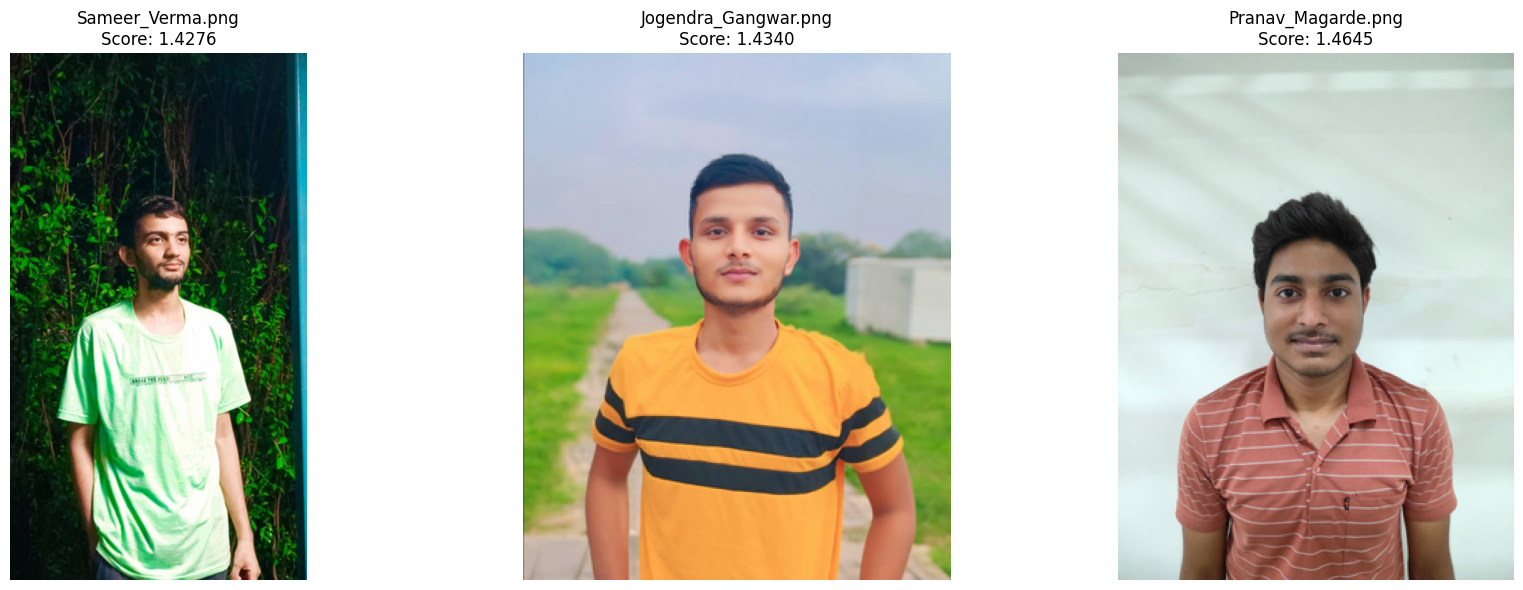

In [41]:
query = "Image of a man with yellow tshirt with black stripes and having a green background"
top_k = 3

retrieved_files, scores = retrieve_relevant_images(query, k=top_k)

print(f"\nQuery: '{query}'")
print("--- Top 3 Retrieved Images ---")

if not retrieved_files:
    print("No results found.")
else:
    plt.figure(figsize=(18, 6))
    for i, file_name in enumerate(retrieved_files):
        print(f"{i+1}. Filename: {file_name} (Distance Score: {scores[i]:.4f})")

        image_path = os.path.join(IMAGES_DIR, file_name)

        try:
            image = Image.open(image_path)
            ax = plt.subplot(1, top_k, i + 1)
            ax.imshow(image)
            ax.set_title(f"{file_name}\nScore: {scores[i]:.4f}")
            ax.axis("off")
        except FileNotFoundError:
            print(f"  - Error: Could not find image file at {image_path}")

    plt.tight_layout()
    plt.show()